# EDA Charts

This file creates a bar charts of violations by state, year, and contaminant code(s).

In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

DATA_DIR = '../../../../../data'
SDWIS_DIR = os.path.join(DATA_DIR, 'sdwis')

## Fetch data into DataFrames

In [2]:
water_sys = (
    pd.read_csv(os.path.join(SDWIS_DIR, 'WATER_SYSTEM.csv'), low_memory=False)
    [['WATER_SYSTEM.PWSID', 'WATER_SYSTEM.PWS_TYPE_CODE', 'WATER_SYSTEM.STATE_CODE']]
)
water_sys.head()

,WATER_SYSTEM.PWSID,WATER_SYSTEM.PWS_TYPE_CODE,WATER_SYSTEM.STATE_CODE
0,AR1900063,TNCWS,AR
1,AR1900071,TNCWS,AR
2,AR1900072,TNCWS,AR
3,AR1900075,TNCWS,AR
4,AR1900076,TNCWS,AR


In [3]:
viol = (
    pd.read_csv(os.path.join(SDWIS_DIR, 'VIOLATION.csv'), low_memory=False)
    [['VIOLATION.PWSID', 'VIOLATION.CONTAMINANT_CODE', 'VIOLATION.COMPL_PER_BEGIN_DATE', 'VIOLATION.IS_HEALTH_BASED_IND']]
    .drop_duplicates()
)

# uncomment line if you want only health based violations
# viol = viol.loc[viol['IS_HEALTH_BASED_IND'] == 'Y', :]

# this is a workaround, ideally CONTAMINANT_CODE should be a string
viol.loc[:, 'CONTAMINANT_CODE_STR'] = viol['VIOLATION.CONTAMINANT_CODE'].astype(str).str.zfill(4)
viol.head()

,VIOLATION.PWSID,VIOLATION.CONTAMINANT_CODE,VIOLATION.COMPL_PER_BEGIN_DATE,VIOLATION.IS_HEALTH_BASED_IND,CONTAMINANT_CODE_STR
0,WI1110274,2378,01-JUL-12,N,2378
1,WI1110274,2991,01-JUL-12,N,2991
2,WI1110274,3100,01-JUL-12,Y,3100
3,WI1110274,2992,01-JUL-12,N,2992
4,WI1110274,3100,01-OCT-11,Y,3100


## Join violations to dictionary of contaminants, to get names

In [4]:
contaminant_codes = pd.read_csv(os.path.join(SDWIS_DIR, 'contaminant-codes.csv'), sep=',',
                                dtype={'CODE' : np.str})
contaminant_codes = contaminant_codes.rename(index=str, columns={"NAME": "CONTAMINANT"})
contaminant_codes[contaminant_codes['CONTAMINANT'] == "LEAD"]


,CODE,CONTAMINANT,SCIENTIFIC_NAME,TYPE_CODE
39,1030,LEAD,NaN,IOC


In [5]:
viol = pd.merge(viol, contaminant_codes, left_on='CONTAMINANT_CODE_STR', right_on='CODE', how='left')
viol = viol[['VIOLATION.PWSID', 'VIOLATION.CONTAMINANT_CODE', 'CONTAMINANT', 'VIOLATION.COMPL_PER_BEGIN_DATE']].drop_duplicates()
viol.head()

,VIOLATION.PWSID,VIOLATION.CONTAMINANT_CODE,CONTAMINANT,VIOLATION.COMPL_PER_BEGIN_DATE
0,WI1110274,2378,"1,2,4-TRICHLOROBENZENE",01-JUL-12
1,WI1110274,2991,TOLUENE,01-JUL-12
2,WI1110274,3100,COLIFORM (TCR),01-JUL-12
3,WI1110274,2992,ETHYLBENZENE,01-JUL-12
4,WI1110274,3100,COLIFORM (TCR),01-OCT-11


In [6]:
viol.loc[:, 'VIOLATION_YEAR'] = pd.to_datetime(viol['VIOLATION.COMPL_PER_BEGIN_DATE']).dt.year

In [7]:
water_sys_viol = pd.merge(water_sys, viol, left_on='WATER_SYSTEM.PWSID', right_on='VIOLATION.PWSID')
water_sys_viol.head()

,WATER_SYSTEM.PWSID,WATER_SYSTEM.PWS_TYPE_CODE,WATER_SYSTEM.STATE_CODE,VIOLATION.PWSID,VIOLATION.CONTAMINANT_CODE,CONTAMINANT,VIOLATION.COMPL_PER_BEGIN_DATE,VIOLATION_YEAR
0,CA3600530,TNCWS,CA,CA3600530,3100,COLIFORM (TCR),01-JUL-12,2012
1,CA3600541,TNCWS,CA,CA3600541,3000,COLIFORM (PRE-TCR),01-OCT-81,1981
2,CA3600541,TNCWS,CA,CA3600541,3000,COLIFORM (PRE-TCR),15-MAR-85,1985
3,CA3600541,TNCWS,CA,CA3600541,3000,COLIFORM (PRE-TCR),01-OCT-84,1984
4,CA3600541,TNCWS,CA,CA3600541,3000,COLIFORM (PRE-TCR),31-AUG-88,1988


In [8]:
# df: water system violation dataframe
# state: two letter code
# contaminant_codes: enter empty array for all
def get_num_violations(df, state, min_year, max_year, contaminant_codes=[]):
    if len(contaminant_codes) > 0:
        return df.loc[(df['WATER_SYSTEM.STATE_CODE']==state) &
                      (df['VIOLATION_YEAR'] >= min_year) &
                      (df['VIOLATION_YEAR'] <= max_year) &
                      (df['VIOLATION.CONTAMINANT_CODE'].isin(contaminant_codes))
                 ]
    else:
        return df.loc[(df['WATER_SYSTEM.STATE_CODE']==state) &
                      (df['VIOLATION_YEAR'] >= min_year) &
                      (df['VIOLATION_YEAR'] <= max_year)
                 ]


## Plot number of violations on a bar chart

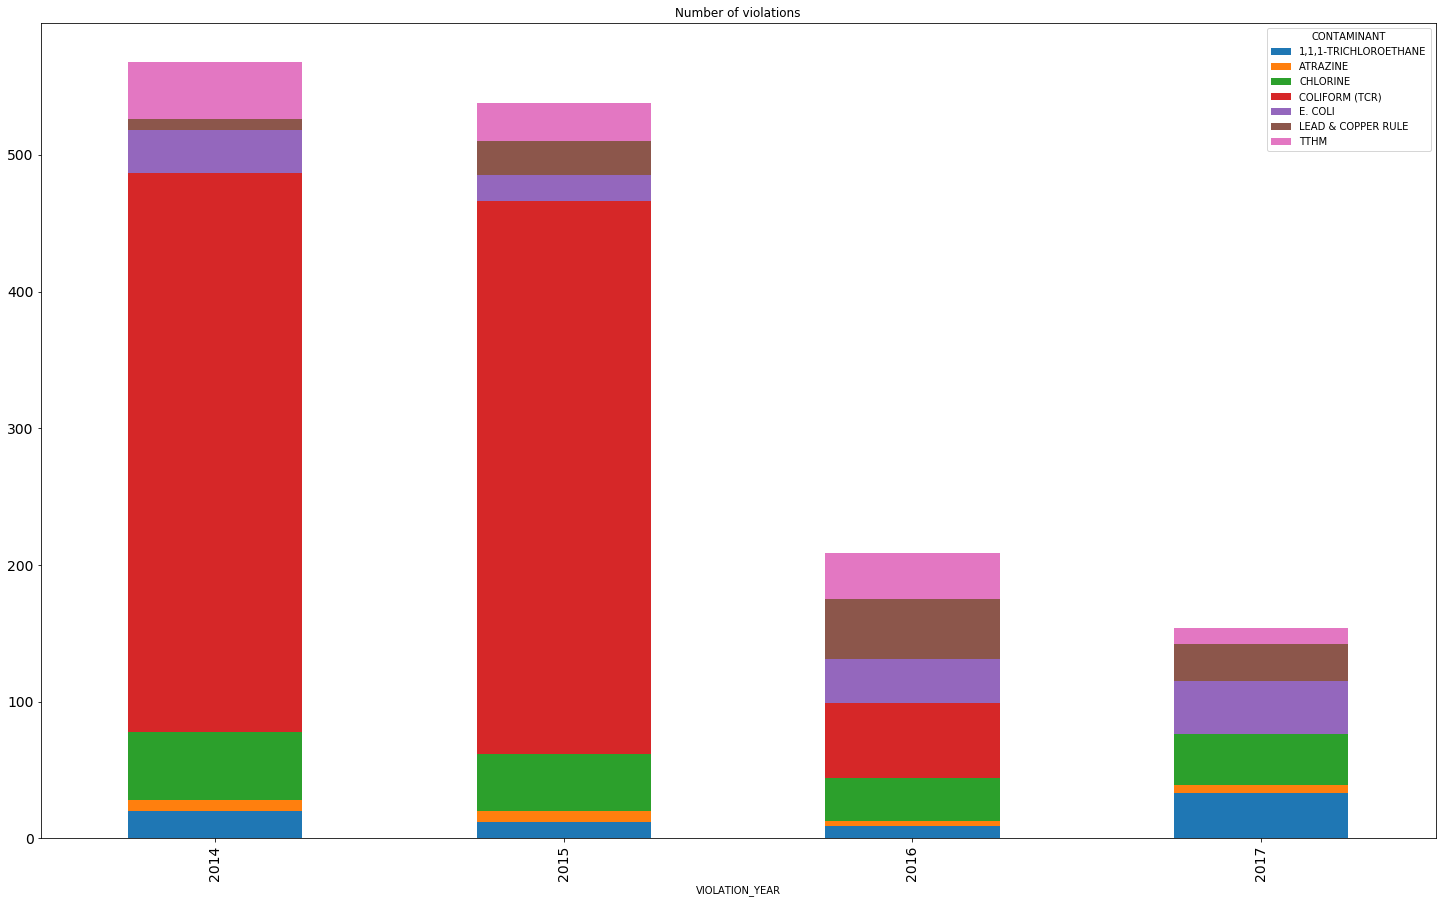

In [9]:
# Violations in the state between 2008 and 2018
contaminant_codes = ['0999', '1030', '2050', '2950', '2981', '3014', '3100', '5000'] # pass this optionally to filter by contaminant

# 
'''
lead 1030
coliform 3000
fecal coliform 3030
ecoli 3014
coliform(tcr) 3100
chlorine 999
tthm 2950
atrazine 2050
1,1,1-trichloroethane 2981
'''

df = get_num_violations(water_sys_viol, 'VT', 2014, 2017, contaminant_codes)
s1 = df.groupby(['CONTAMINANT', 'VIOLATION_YEAR']).size()

if len(s1.index) > 0:
    df3 = s1.unstack()
    df3.T.plot.bar(stacked=True, figsize = (25,15), title='Number of violations', fontsize=14)
else:
    print ('No data to chart')